In [1]:
from dataset_evaluation import (sentence_level_quality,
                                fidelity,
                                Predictor)
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from datasets import load_dataset

Some weights of BertModel were not initialized from the model checkpoint at jjzha/jobbert-base-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
pipe = lambda plot, comms : [comm(plot) for comm in comms]

def get_all_metrics(df,
                    sentence_key="sentence",
                    label_key="skills",):
    D = 3 ## number of drawings
    f, axs = plt.subplots(D, 1, figsize=(15, 10))


    ### FIDELITY     
    data_fidelity = fidelity(
        list(
            df.dropna()[sentence_key]
        ),
        model_id="gpt2"
    )
    MEAN_FIDELITY = data_fidelity["mean_perplexity"]
    MEDIAN_FIDELITY = np.median(data_fidelity["perplexities"])
    # display(pd.DataFrame(data_fidelity).sort_values("perplexities", ascending=False))
    pipe(
        sns.boxplot(
        data=pd.DataFrame(data_fidelity), 
        x="perplexities",
        ax=axs[0]
        ),
        [
            lambda x : x.set_title("Distribution of the perplexities of the dataset's sample"),
            lambda x : x.set_xlabel("Perplexity through GPT2"),
            lambda x : x.set_ylabel("Number of samples")

        ]  
    )

    data_fidelity_base = pd.DataFrame(data_fidelity)
    data_fidelity_filtered = data_fidelity_base[
        data_fidelity_base < np.percentile(data_fidelity_base.perplexities, 95)
    ]
    pipe(
        sns.boxplot(
        data=data_fidelity_filtered, 
        x="perplexities",
        ax=axs[1]
        ),
        [
            lambda x : x.set_title("Distribution of the perplexities of the dataset's sample"),
            lambda x : x.set_xlabel("Perplexity through GPT2"),
            lambda x : x.set_ylabel("Number of samples")

        ]  
    )

    ### SLQ
    slq = sentence_level_quality(df.explode(label_key)\
                                 .query(f"{label_key} != 'UNK'"),
                                 label_key=label_key)
    MEAN_SLQ = slq.sim.mean()
    MEDIAN_SLQ = slq.sim.median()

    pipe(
        sns.histplot(
        data=slq.reset_index(),
        x="sim",
        ax=axs[2]
        ),
        [
            lambda x : x.set_title("Distribution the semantic similarity between the sentence and the associated skill"),
            lambda x : x.set_xlabel("Cosine similarity"),
            lambda x : x.set_ylabel("Number of (sentence, skill) pair"),
            lambda x : x.set_xlim((0, 1))
            
        ]
    )

    plt.tight_layout()

    return {
        "MEAN_FIDELITY" : MEAN_FIDELITY,
        "MEDIAN_FIDELITY" : MEDIAN_FIDELITY,
        "MEAN_SLQ" : MEAN_SLQ,
        "MEDIAN_SLQ" : MEDIAN_SLQ
    }


### Baseline 1 - SkillSpan

| Metric | SkillSpan |
|:------:|:---------:| 
| ELQ | X |
| SLQ (median) | 0.67 |
| SLQ (mean) | 0.662 |
| Fidelity (mean) | ~ |
| Fidelity (median) | 178 |

In [3]:
## test set for skillspan
with open("../../../esco/test.json") as f:
    testsp = pd.DataFrame(
        eval(
            ",".join(f.read().split("\n"))
        )
    ).drop("idx", axis=1)
    testsp.columns = ["sentence", "skills"]
    if(type(testsp.skills[0]) == "str"):
        testsp["skills"] = testsp["skills"].apply(eval)
testsp.head(5)

,sentence,skills
0,Work in a way that is patient-centred and incl...,"[apply person-centred care, UNK]"
1,Provide your patients with a safe and effectiv...,"[formulate a treatment plan, develop patient t..."
2,See IT systems as an aid in your work and do w...,[UNK]
3,Be good humoured loyal dedicated and flexible .,"[practice humour, UNK]"
4,As a promotor you therefore need to engage peo...,"[engage passers-by in conversation, promote th..."


In [39]:
import re
pattern = r'<(.*?)>'

special_tokens = set(sum(
    testsp.sentence.apply(
        lambda st : re.findall(pattern, st)
    ).to_list(), 
    []
))
display(special_tokens)

top = testsp.sentence.apply(lambda x : any(sp in x for sp in special_tokens))
print(f"{round(top.sum() * 100 / len(testsp), 2)}% of the datapoints contain a special token.")

{'CONTACT', 'LOCATION', 'NAME', 'ORGANIZATION', 'PROFESSION'}

4.79% of the datapoints contain a special token.


In [46]:
display(list(testsp[~top].sentence))
display(list(testsp[top].sentence))

['Work in a way that is patient-centred and inclusive .',
 'Provide your patients with a safe and effective course of treatment .',
 'See IT systems as an aid in your work and do what you can to be at the forefront of developments in this area .',
 'Be good humoured loyal dedicated and flexible .',
 'You are: Extroverted and energetic Excited about meeting new people and enjoy interacting with many different characters .',
 'Result oriented and work constructively towards reaching goals .',
 'Good at acquiring new skills and using them actively to improve your performance .',
 'Motivated by overcoming obstacles and continuously working on your own development .',
 'Danish skills are not necessary some of our best fundraisers only speak English',
 'You must be able to read and understand addresses and house numbers',
 "Good team work and cooperation with your colleagues and daily leader 3F's union agreement with DMA",
 'You can walk on stairs',
 'You can ride a bike',
 'You have a accep

['As a promotor you therefore need to engage people in the streets and inspire them to support the cause by conveying knowledge about how <ORGANIZATION> works .',
 'You must however hold a valid visa to work in <LOCATION> in order to be considered for the position .',
 'As <PROFESSION> for Digital Supply Chain Community you will drive the Digital Supply Chain Community globally which consists of representatives from our four business segments IT procurement and corporate functions .',
 'You will create impact with differentiating Danfoss digitally by developing and implementing a Digital Supply Chain strategy sharing best practice across <ORGANIZATION> and developing new initiatives in cooperation with the Digital Supply Chain Community .',
 'Digital Savvy and experienced in fields like data analytics process transformation IoT ( Industrial Automation ) and new business models ( e-commerce startups agile ) Excellent communication presentation and facilitation skills Well-structured and

Using pad_token, but it is not set yet.


  0%|          | 0/47 [00:00<?, ?it/s]

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


  0%|          | 0/902 [00:00<?, ?it/s]

  0%|          | 0/902 [00:00<?, ?it/s]

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


{'MEAN_FIDELITY': 906.2466534971397,
 'MEDIAN_FIDELITY': 178.15480041503906,
 'MEAN_SLQ': 0.66207635,
 'MEDIAN_SLQ': 0.6722068}

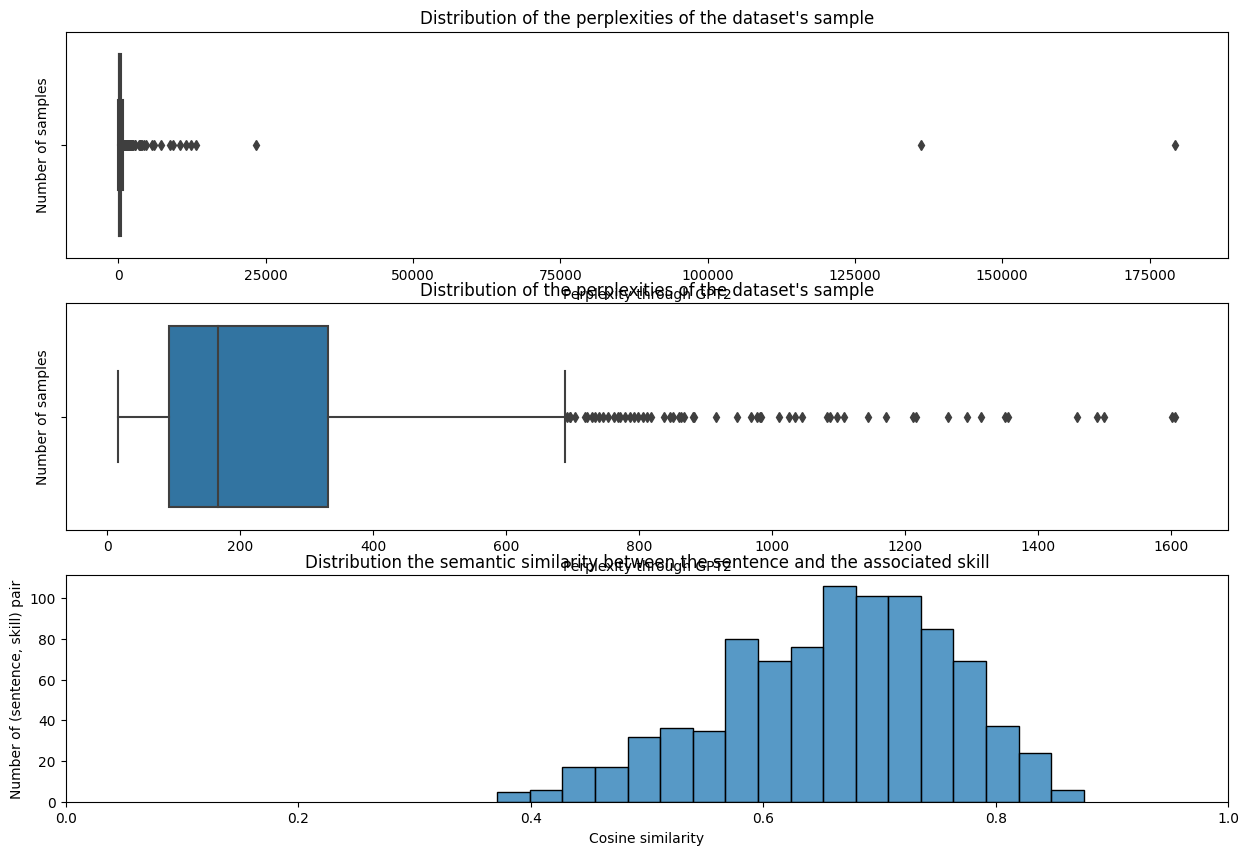

In [66]:
get_all_metrics(
    testsp
)

In [56]:
ids = [601, 587, 347]
list(testsp[~top].iloc[ids].sentence)

['qa python automation', 'qa automation testing', 'Personal efficiency;']

In [58]:
fidelity(['qa python automation', 'qa automation testing', 'Personal efficiency;'],
 model_id="gpt2")

Using pad_token, but it is not set yet.


  0%|          | 0/1 [00:00<?, ?it/s]

{'perplexities': [179377.71875, 136161.78125, 23315.73828125],
 'mean_perplexity': 112951.74609375}

### Decorte

In [41]:
dec_test = pd.read_csv("https://raw.githubusercontent.com/jensjorisdecorte/Skill-Extraction-benchmark/main/tech_test_annotations.csv")
dec_test = dec_test.groupby("sentence").agg({"label": lambda x : x.tolist() , "span": lambda x : x.tolist()}).reset_index()
dec_test

,sentence,label,span
0,( Cypress for frontend is a must have pytest f...,"[LABEL NOT PRESENT, LABEL NOT PRESENT, LABEL N...","[Cypress, pytest, truffle, Solidity]"
1,* Ability to analyse requirements and interact...,"[analyse business requirements, communicate wi...","[analyse requirements, interact directly with ..."
2,* Ability to support the developers in your te...,"[manage a team, lead others, mentor individual...","[support the developers in your team, leading,..."
3,* Ability to work in large collaborative teams...,"[work in teams, meet commitments, work in team...","[work in large collaborative teams, achieve or..."
4,* Ability to work in large collaborative teams...,"[work in teams, meet commitments, think innova...","[work in large collaborative teams, achieve or..."
...,...,...,...
420,• Streamlining integration across issue tracki...,"[LABEL NOT PRESENT, deploy ICT systems, ICT sy...","[issue tracking, deployment, Streamlining inte..."
421,• Understand operational processes in order to...,"[solve problems, advise on efficiency improvem...","[provide solutions, improve operational effici..."
422,• Very good understanding of test automation f...,[tools for ICT test automation],[test automation frameworks .]
423,• Work collaboratively in teams and develop me...,"[work in teams, establish collaborative relati...","[Work collaboratively in teams, develop meanin..."


Using pad_token, but it is not set yet.


  0%|          | 0/27 [00:00<?, ?it/s]

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


  0%|          | 0/1164 [00:00<?, ?it/s]

  0%|          | 0/1164 [00:00<?, ?it/s]

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


{'MEAN_FIDELITY': 1350.7001264056037,
 'MEDIAN_FIDELITY': 188.05096435546875,
 'MEAN_SLQ': 0.6475825381690058,
 'MEDIAN_SLQ': 0.6565722227096558}

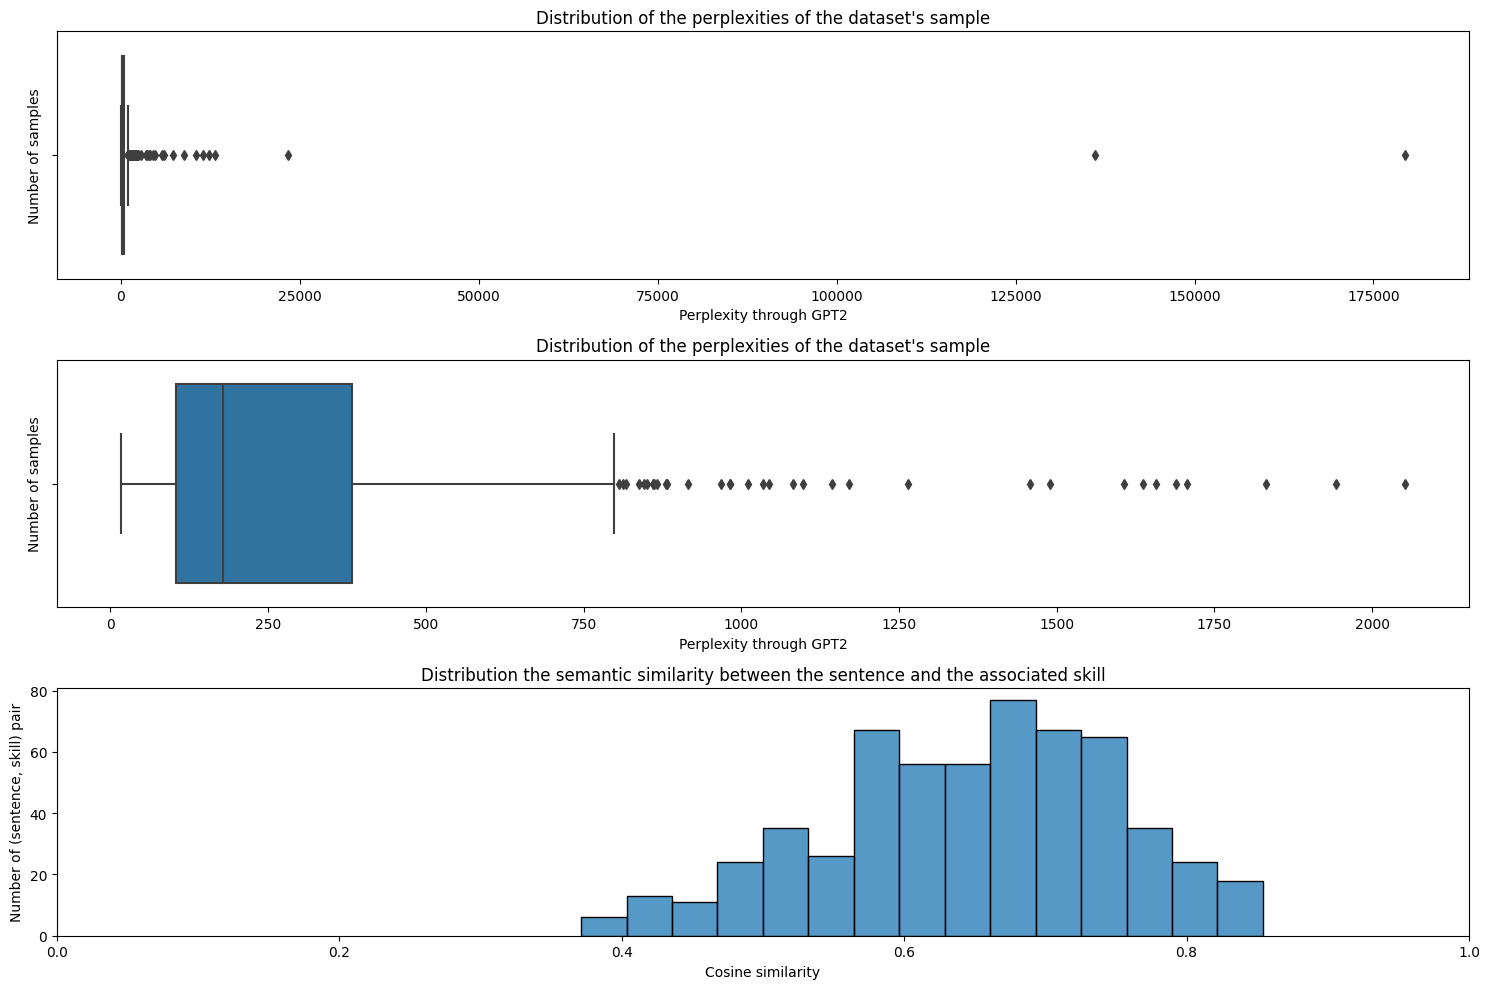

In [82]:
get_all_metrics(dec_test,
                label_key="label",
                sentence_key="sentence")

| Metric | SkillSpan |
|:------:|:---------:| 
| ELQ | X |
| SLQ (median) | 0.656 |
| SLQ (mean) | 0.647 |
| Fidelity (mean) | ~ |
| Fidelity (median) | 188 |

### Generated SkillSpan

Using pad_token, but it is not set yet.


  0%|          | 0/80 [00:00<?, ?it/s]

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


  0%|          | 0/2199 [00:00<?, ?it/s]

  0%|          | 0/2199 [00:00<?, ?it/s]

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


{'MEAN_FIDELITY': 50.64009455015074,
 'MEDIAN_FIDELITY': 44.28851509094238,
 'MEAN_SLQ': 0.7514897558032367,
 'MEDIAN_SLQ': 0.7579870820045471}

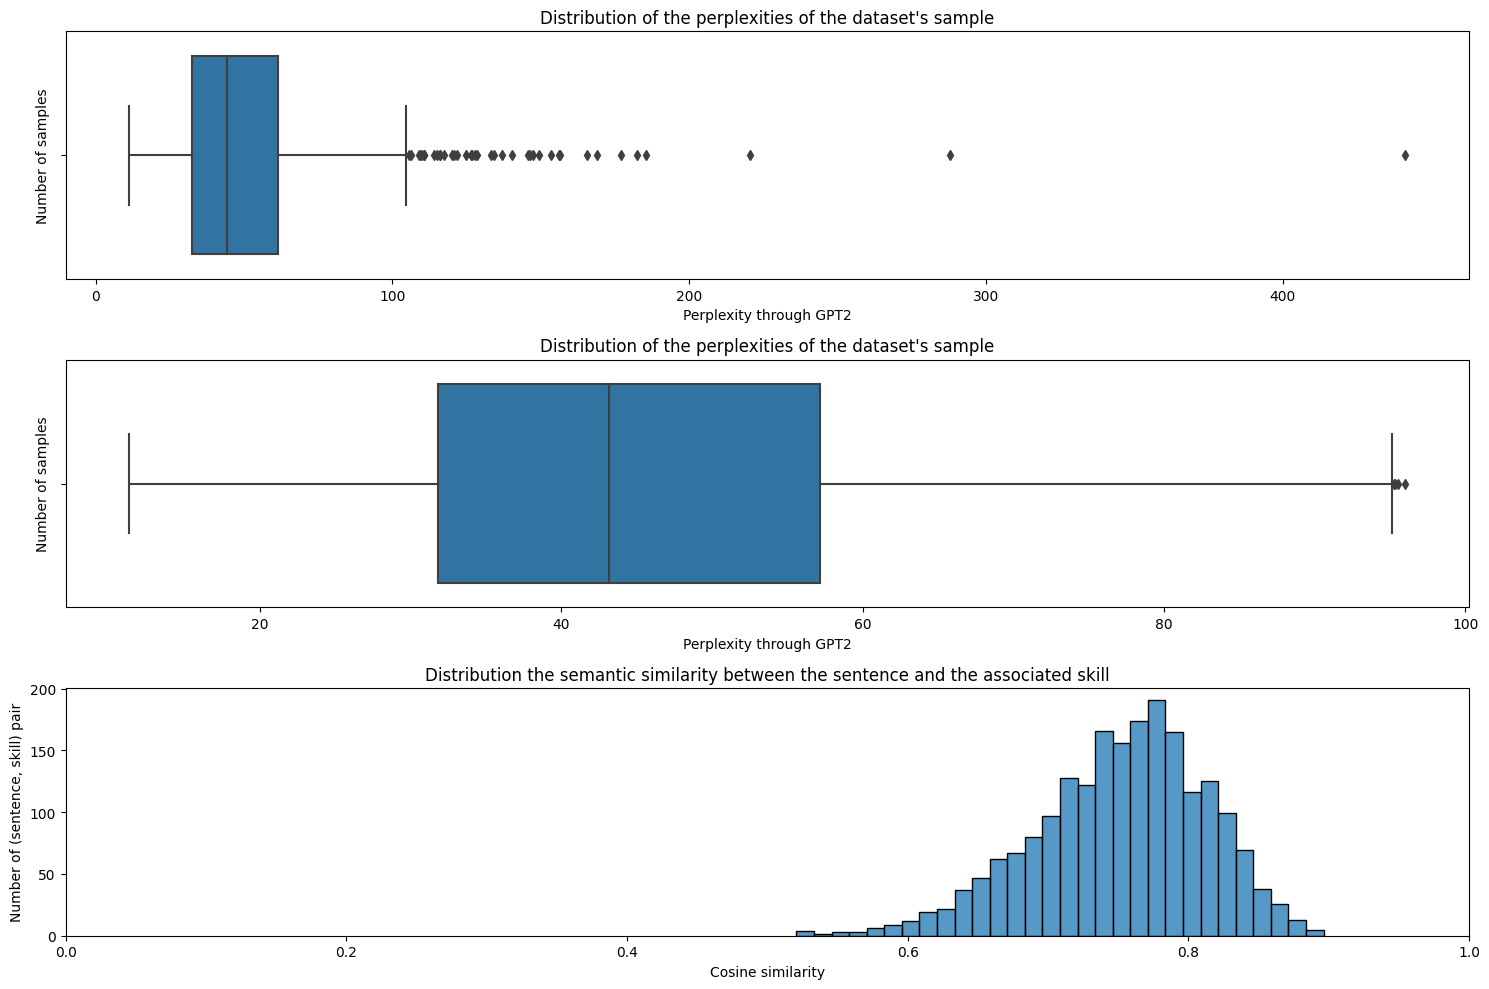

In [11]:
ds = pd.read_csv("generation/generated/SKILLSPAN/test_final.csv")
ds["skills"] = ds["skills"].apply(eval)
ds = ds[["sentence", "skills"]].dropna()

get_all_metrics(
    ds,
    label_key="skills"
)

| Metric | SkillSpan |
|:------:|:---------:| 
| ELQ | X |
| SLQ (median) | 0.758 |
| SLQ (mean) | 0.751 |
| Fidelity (mean) | ~ |
| Fidelity (median) | 50.6 |

## Adding ELQ

To compute the ELQ we will compute how the pipeline model gets to discover the embedded skills. With no special supports.

In [4]:
predictor = Predictor(test_domain="SkillSpan-test",
                      train_domain="SkillSpan", ## no training will be used anyway
                      candidates_method="mixed")


def computed_confusion_matrix(preds):
    TP = 0
    TPs = []
    FN = 0
    FNs = []
    FP = 0
    FPs = []
    for item in preds:
        titem = item[0]
        
        label_skills = titem["skills"]
        matched_sk = []
        for mskill in titem["matched_skills"]:

            skill_item = titem['matched_skills'][mskill]
            skill_name = skill_item["name+definition"].split(" : ")[0]
            if(skill_name in titem["skills"]):
                TP += 1 ## we predicted a label and indeed in the target ==> TP
                TPs.append([skill_name, titem["skills"]])
            else :
                FP += 1 ## we predicted a lebl as positive but it's false
                FPs.append([skill_name, titem["skills"]])
            matched_sk.append(skill_item)
        for skill in titem["skills"]:
            if(skill != "UNK"):
                if(skill not in matched_sk):
                    FN += 1 ## we predicted a label as not in the skills but it it ==> false negative
                    FNs.append([skill, matched_sk])

    return TP, FN, FP

def compute_metrics(preds):
    TP, FN, FP = computed_confusion_matrix(preds)
    R = TP / (TP + FN) if(TP + FN != 0) else 0
    P = TP / (TP + FP) if(TP + FP != 0) else 0
    
    # print("Precision : ", P)
    # print("Recall : ", R)
    # print("F1 : ", 2*P*R/(P + R))
    return R, P, (2*P*R/(P + R) if ((P + R) != 0) else 0)


In [ ]:
bootstrap_metrics = []
for i in range(10):
    subds = ds.sample(n=200, replace=True).to_dict("records")
    sp = predictor.pipeline_prediction(subds, 
                                    support_type=None) ## base prediction
    bootstrap_metrics.append(compute_metrics(sp))
    

In [61]:
#### For Generated 

bootstrap_metrics_gen = np.sort([x[2] for x in bootstrap_metrics])
print("The achived precision is contained with 90% chance between ", 
      bootstrap_metrics_gen[0],
      "and ",
      bootstrap_metrics_gen[9])

The achived precision is contained with 90% chance between  0.2521419828641371 and  0.2867383512544803


In [ ]:
# dec_test = dec_test[["sentence", "label"]]
# dec_test.columns = ["sentence", "skills"]
bootstrap_metrics_dec = []
for i in range(10):
    subds = dec_test.sample(n=200, replace=True).to_dict("records")
    dec_sp = predictor.pipeline_prediction(subds, 
                                    support_type=None) ## base prediction
    bootstrap_metrics_dec.append(compute_metrics(dec_sp))
    

In [ ]:
## For Decorte

bootstrap_f1_dec = np.sort([x[2] for x in bootstrap_metrics_dec])
print("The achived precision is contained with 90% chance between ", 
      bootstrap_f1_dec[0],
      "and ",
      bootstrap_f1_dec[9])

In [ ]:
# dec_test = dec_test[["sentence", "label"]]
# dec_test.columns = ["sentence", "skills"]
bootstrap_metrics_sp = []
for i in range(10):
    subds = testsp.sample(n=200, replace=True).to_dict("records")
    dec_sp = predictor.pipeline_prediction(subds, 
                                    support_type=None) ## base prediction
    bootstrap_metrics_sp.append(compute_metrics(dec_sp))
    

In [ ]:
## For SkillSpan

bootstrap_f1_sp = np.sort([x[2] for x in bootstrap_metrics_sp])
print("The achived precision is contained with 90% chance between ", 
      bootstrap_f1_dec[0],
      "and ",
      bootstrap_f1_dec[9])

In [7]:
print("SkillSpan :", bootstrap_f1_sp.mean())
print("Decorte ; ", 0.15474592062822654)
print("Generated : ", 0.2659013630558146)

SkillSpan : 0.22107526688807733
Decorte ;  0.15474592062822654
Generated :  0.2659013630558146
